In [41]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [42]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [44]:
np.random.seed(0)

In [45]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [46]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [47]:
assert(X_train.shape[0] == y_train.shape[0]), "Number of images not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "Number of images not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "Number of images not equal to number of labels"
assert(X_train.shape[1:]) == (32,32,3), "Dimension mismatch"
assert(X_val.shape[1:]) == (32,32,3), "Dimension mismatch"
assert(X_test.shape[1:]) == (32,32,3), "Dimension mismatch"

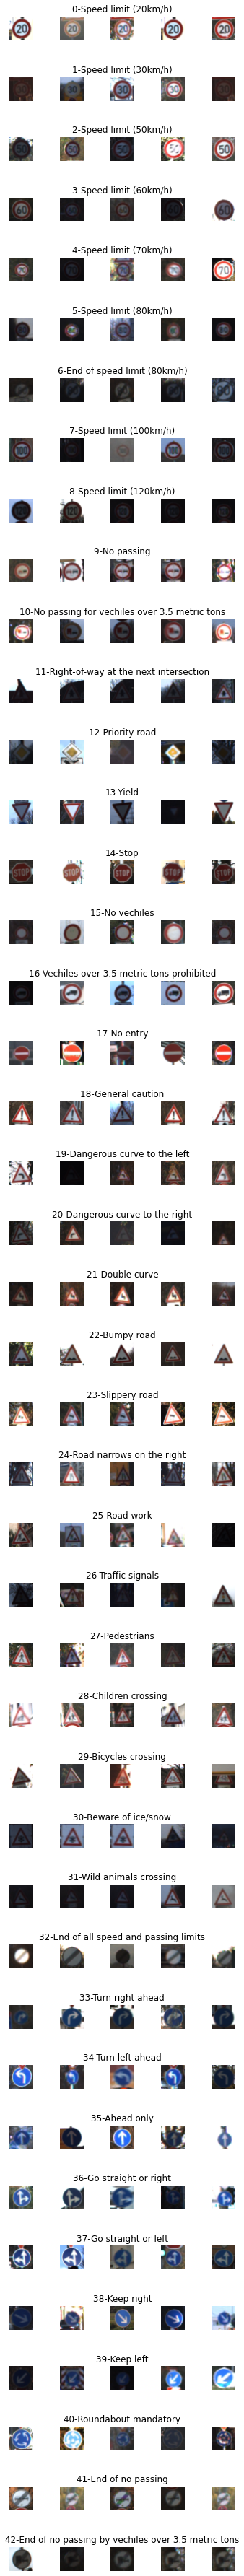

In [48]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5,50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1))], cmap = plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


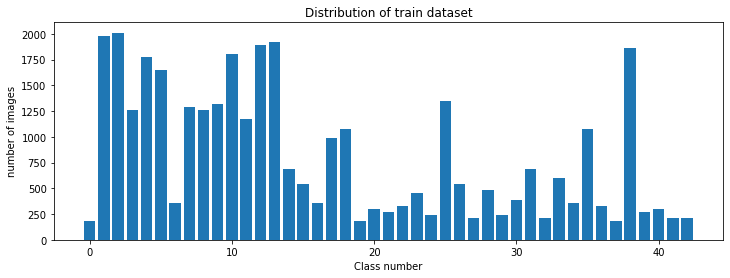

In [49]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of train dataset")
plt.xlabel("Class number")
plt.ylabel("number of images")
plt.show()

(32, 32, 3)
36


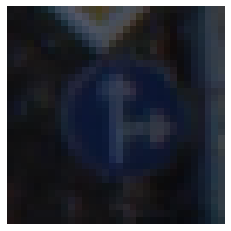

In [50]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


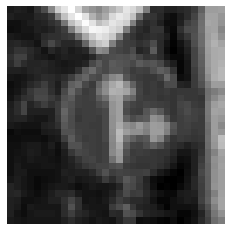

In [51]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

(32, 32)


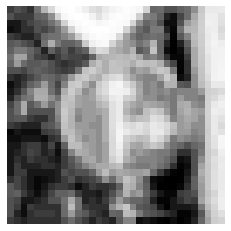

In [52]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)

plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [53]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

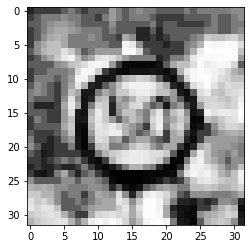

In [54]:
plt.imshow(X_train[random.randint(0, len(X_train -1))], cmap = 'gray')

In [55]:
X_train = X_train.reshape(34799,32,32,1)
X_val = X_val.reshape(4410,32,32,1)
X_test = X_test.reshape(12630,32,32,1)

In [56]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)
datagen.fit(X_train)

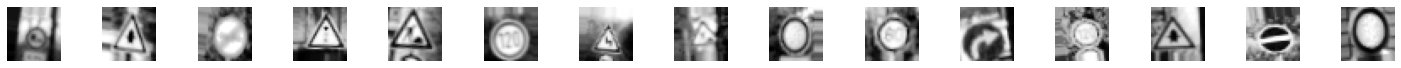

In [57]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch,y_batch = next(batches)

fig,axs = plt.subplots(1,15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap = plt.get_cmap('gray') )
  axs[i].axis('off')

In [58]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [59]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [60]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [61]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [69]:
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size = 50), steps_per_epoch = 200, epochs = 50, validation_data = (X_val,y_val),shuffle = 1, verbose = 1)

Epoch 1/50
  7/200 [>.............................] - ETA: 3s - loss: 0.1213 - accuracy: 0.9686

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


200/200 [==============================] - 4s 20ms/step - loss: 0.1477 - accuracy: 0.9561 - val_loss: 0.0607 - val_accuracy: 0.9846
Epoch 2/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1382 - accuracy: 0.9565 - val_loss: 0.0476 - val_accuracy: 0.9862
Epoch 3/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1700 - accuracy: 0.9480 - val_loss: 0.0415 - val_accuracy: 0.9880
Epoch 4/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1369 - accuracy: 0.9557 - val_loss: 0.0415 - val_accuracy: 0.9866
Epoch 5/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1238 - accuracy: 0.9602 - val_loss: 0.0646 - val_accuracy: 0.9812
Epoch 6/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1208 - accuracy: 0.9634 - val_loss: 0.0411 - val_accuracy: 0.9878
Epoch 7/50
200/200 [==============================] - 4s 20ms/step - loss: 0.1265 - accuracy: 0.9601 - val_loss: 0.0492 - val_accuracy: 0.9864
Epoch 8/50

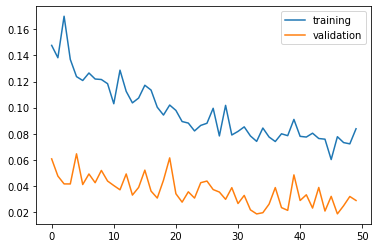

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

In [71]:
score = model.evaluate(X_test,y_test,verbose= 0)

print('Test Score:', score[0])
print('Test accuracy:', score[1])

Test Score: 0.12597252428531647
Test accuracy: 0.9688836336135864


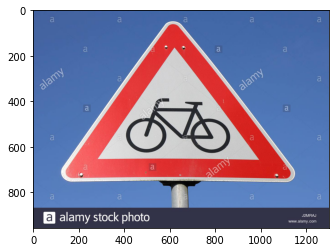

In [72]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


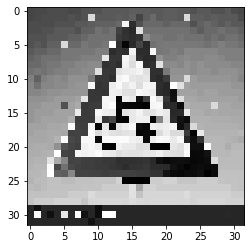

In [73]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [74]:
img = img.reshape(1, 32, 32, 1)

In [75]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [23]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
